# Test the Adaptive Normal proposal with the Parallel Tempered Sampler

In this notebook we will test the adaptive normal proposal on a 2D Gaussian distribution with mean $\bar{x} = 2, \bar{y} = 5$ and variance $\sigma_x^2 = 1$, $\sigma_y^2 = 2$; $\sigma^2_{xy} = \sigma^2_{yx} = 0$, using a prior that is uniform over $x \in [-20, 20)$ and $y \in [-40, 40)$. For this we will use the parallel tempered sampler.

In [1]:
from __future__ import print_function

%matplotlib notebook
from matplotlib import pyplot
import numpy
import randomgen

import epsie
from epsie import make_betas_ladder
from epsie.samplers import ParallelTemperedSampler
from epsie.proposals import AdaptiveNormal
import multiprocessing

## Create the model to sample

***Note:*** Below we create a class with several functions to draw samples from the prior and to evaluate the log posterior. This isn't strictly necessary. The only thing the Sampler really requires is a function that it can pass keyword arguments to and get back a tuple of (log likelihood, log prior). However, setting things up as a class will make it convenient to, e.g., draw random samples from the prior for the starting positiions, as well as plot the model later on.

In [2]:
from scipy import stats
class Model(object):
    def __init__(self):
        # we'll use a 2D Gaussian for the likelihood distribution
        self.params = ['x', 'y']
        self.mean = [2., 5.]
        self.cov = [[1., 0.], [0., 2.]]
        self.likelihood_dist = stats.multivariate_normal(mean=self.mean,
                                                         cov=self.cov)

        # we'll just use a uniform prior
        self.prior_bounds = {'x': (-20., 20.),
                             'y': (-40., 40.)}
        xmin = self.prior_bounds['x'][0]
        dx = self.prior_bounds['x'][1] - xmin
        ymin = self.prior_bounds['y'][0]
        dy = self.prior_bounds['y'][1] - ymin
        self.prior_dist = {'x': stats.uniform(xmin, dx),
                           'y': stats.uniform(ymin, dy)}

    def prior_rvs(self, size=None, shape=None):
        return {p: self.prior_dist[p].rvs(size=size).reshape(shape)
                for p in self.params}
    
    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])
    
    def loglikelihood(self, **kwargs):
        return self.likelihood_dist.logpdf([kwargs[p] for p in self.params])
    
    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp

In [3]:
model = Model()

## Setup the proposal

We'll setup the adaptive normal proposal to run for 512 iterations.

In [4]:
adaptation_duration = 512
prior_widths = {p: abs(bnds[1] - bnds[0]) for p, bnds in model.prior_bounds.items()}
proposal = AdaptiveNormal(model.params, prior_widths, adaptation_duration=adaptation_duration)

## Setup and run the sampler

Create a pool of 4 parallel processes, then initialize the sampler using the model we created above.

In [5]:
nchains = 12
ntemps = 3
swap_interval = 4
nprocs = 4
pool = multiprocessing.Pool(nprocs)

betas = make_betas_ladder(ntemps, 1e5)
sampler = ParallelTemperedSampler(model.params, model, nchains,
                                  proposals=[proposal],
                                  betas=betas, swap_interval=swap_interval,
                                  pool=pool)

Now set the starting positions of the chains by drawing random variates from the model's prior.

In [6]:
sampler.start_position = model.prior_rvs(size=nchains*ntemps, shape=(ntemps, nchains))

### Let's run it!

This will evolve each chain in the collection by 256 steps. This is parallelized over the pool of processes.

In [7]:
sampler.run(256)

Let's check how the standard deviation has changed. We started with:

In [8]:
print(proposal.std)

[2.7576 5.5152]


Now we have:

In [9]:
# the current covariance of each
for ci, ptchain in enumerate(sampler.chains):
    print('==== Chain {} ===='.format(ci))
    for tk, c in enumerate(ptchain.chains):
        print("Temp {}:".format(tk), c.proposal_dist.proposals[0].std)

==== Chain 0 ====
Temp 0: [2.37101266 4.74202532]
Temp 1: [19.34128261 38.68256521]
Temp 2: [25.74637739 51.49275477]
==== Chain 1 ====
Temp 0: [1.61580827 3.23161654]
Temp 1: [19.82861652 39.65723305]
Temp 2: [26.61696894 53.23393788]
==== Chain 2 ====
Temp 0: [2.1896834  4.37936679]
Temp 1: [22.4649502  44.92990039]
Temp 2: [27.19068604 54.38137209]
==== Chain 3 ====
Temp 0: [1.65074249 3.30148498]
Temp 1: [20.60273334 41.20546667]
Temp 2: [26.15504709 52.31009419]
==== Chain 4 ====
Temp 0: [1.85305266 3.70610533]
Temp 1: [22.57737209 45.15474418]
Temp 2: [25.18680903 50.37361806]
==== Chain 5 ====
Temp 0: [2.38416596 4.76833193]
Temp 1: [22.52251184 45.04502367]
Temp 2: [26.9610402  53.92208039]
==== Chain 6 ====
Temp 0: [2.74602519 5.49205038]
Temp 1: [20.29528921 40.59057842]
Temp 2: [23.96170346 47.92340692]
==== Chain 7 ====
Temp 0: [1.17694613 2.35389225]
Temp 1: [25.26996575 50.5399315 ]
Temp 2: [25.22926537 50.45853074]
==== Chain 8 ====
Temp 0: [2.02998846 4.05997692]
Temp 1

## Plot acceptance rates

We'll plot the acceptance rate for each chain, which we define here as the number of times a proposal was accepted divided by the total number of iterations. We expect this to be close to ~0.23 for the coldest chain, as this was the target rate of the `AdaptiveNormal` proposal that we used.

In [10]:
acceptance = sampler.acceptance
arate = acceptance['accepted'].sum(axis=2)/float(acceptance.shape[-1])
aratio = acceptance['acceptance_ratio']
# limit to 1
aratio[aratio > 1] = 1.
aratio = aratio.mean(axis=2)

<IPython.core.display.Javascript object>


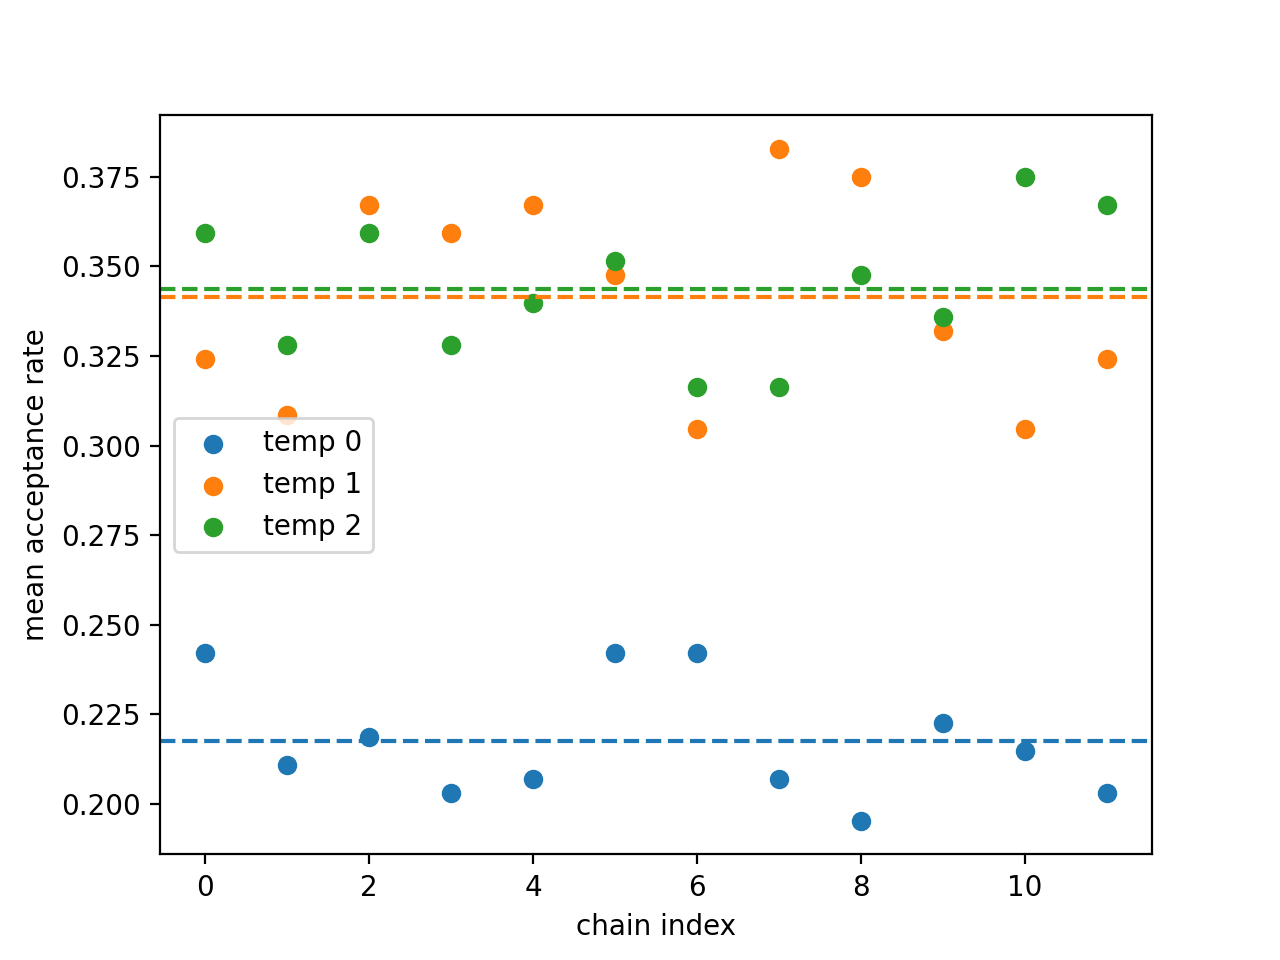

In [11]:
# plot
fig, ax = pyplot.subplots()
for tk in range(ntemps):
    ax.scatter(range(nchains), arate[tk,:], label='temp {}'.format(tk))
    ax.axhline(arate[tk,:].mean(), color='C{}'.format(tk), linestyle='--')
ax.legend()
ax.set_ylabel('mean acceptance rate')
ax.set_xlabel('chain index')
fig.show()

In [12]:
print("Average acceptance rate over all chains:", arate.mean(axis=1))

Average acceptance rate over all chains: [0.21744792 0.34147135 0.34375   ]


Indeed, the average acceptance rate over all of the coldest chains is close to 0.23.

Let's also plot the average acceptance ratio. This should be approximately the same as the acceptance rate.

<IPython.core.display.Javascript object>


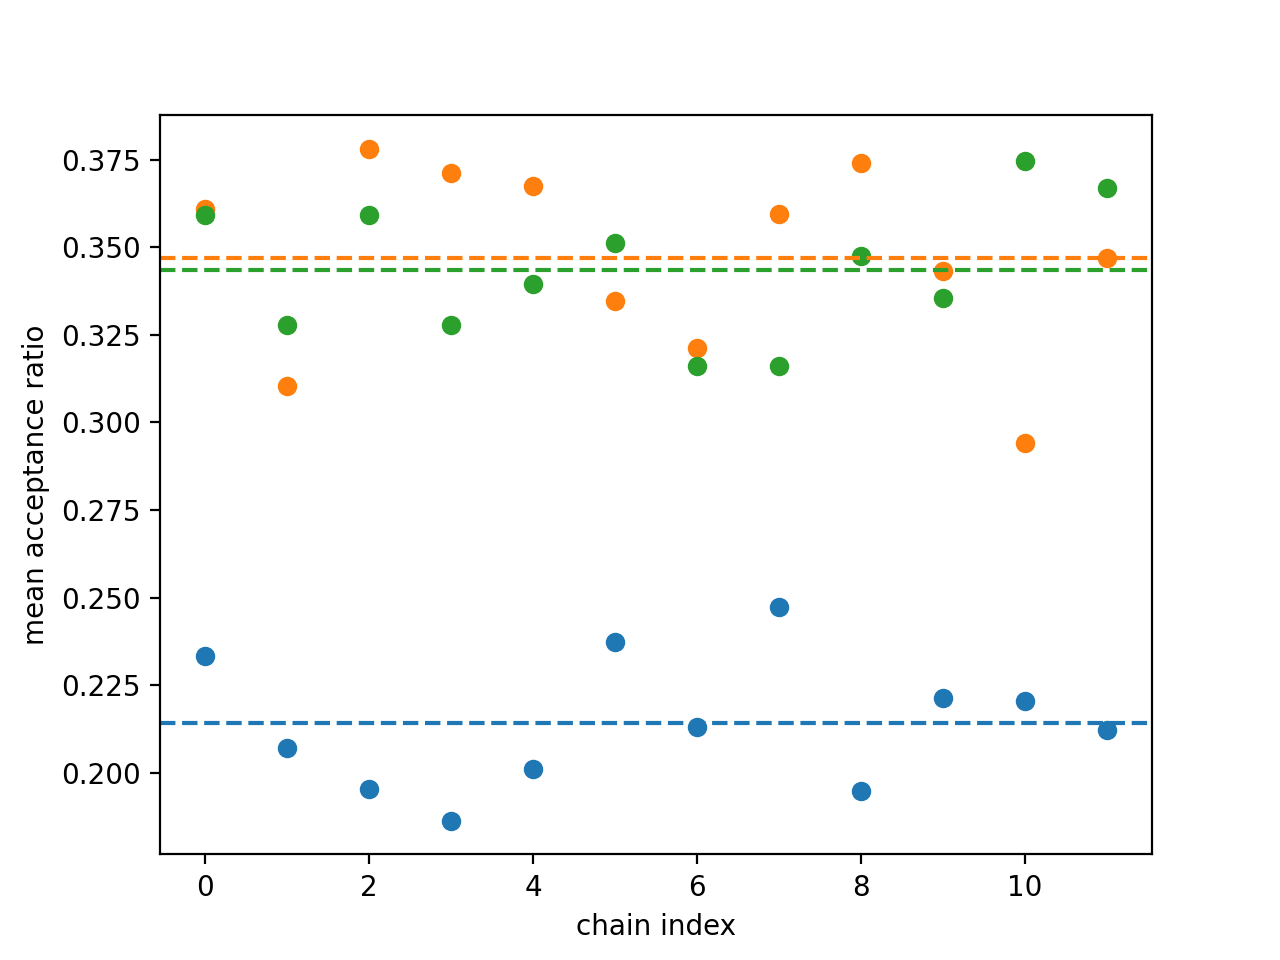

In [13]:
# plot
fig, ax = pyplot.subplots()
for tk in range(ntemps):
    ax.scatter(range(nchains), aratio[tk,:], label='temp {}'.format(tk))
    ax.axhline(aratio[tk,:].mean(), color='C{}'.format(tk), linestyle='--')
ax.set_ylabel('mean acceptance ratio')
ax.set_xlabel('chain index')
fig.show()

In [14]:
print("Average acceptance ratio over all chains:", aratio.mean(axis=1))

Average acceptance ratio over all chains: [0.21410199 0.34683454 0.34349366]


## Resume from a state

The sampler can be checkpointed by getting its current state with `sampler.state`. Let's check that this still works with the `AdaptiveNormal` proposal. To demonstrate this, we'll save the current state of the sampler to a checkpoint HDF5 file, then run it for another set of iterations. We'll then create a new sampler, and set it's state using the checkpoint. Running the same sampler for the same number of iterations should produce the same results.

*Note:* Since we will be reading/writing from an HDF5 file, we'll need `h5py` installed. This is not one of the required packages for epsie, so if you don't have it, uncomment the next line to install it. If you don't wish to use this functionality, or prefer to save checkpoints using pickle or some other file format, you do not need to use HDF5.

In [15]:
#!pip install h5py

In [16]:
import h5py
# open the file to checkpoint to
fp = h5py.File('checkpoint_test.hdf', 'w')
# Dump the checkpoint. By default, the checkpoint will be saved
# to '/sampler_state' in the hdf5 file, but you can change the group
# and dataset name using the path and dsetname arguments, respectively.
sampler.checkpoint(fp)

In [17]:
# now advance the sampler for another 256 iterations
sampler.run(256)

In [18]:
# create a new sampler, but set it's state to what the original sampler's
# was after the first 256 iterations
sampler2 = ParallelTemperedSampler(model.params, model, nchains,
                                   proposals=[proposal],
                                   betas=betas, swap_interval=swap_interval,
                                   pool=pool)
sampler2.set_state_from_checkpoint(fp)

In [19]:
# close the file since we're done with it
fp.close()

In [20]:
# now advance the new sampler for 256 iterations
# note that we don't have to run set_start first, since the
# starting positions have been set by set_start
sampler2.run(256)

In [21]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,:,-1] == sampler2.acceptance['acceptance_ratio'][:,:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,:,-1] == sampler2.acceptance['accepted'][:,:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Clearing memory and continuing

The history of results in memory can be cleared using `.clear()`. Running the sampler after a clear yields the same results as if no clear had been done. This is useful for keeping memory usage down: you can dump results to a file after some number of iterations, clear, then continue.

To demonstrate this, we'll clear `sampler2`, then run both `sampler` and `sampler2` for another 512 iterations. We'll then compare the current results; they should be the same.

We'll also check that the adaptation has ended. Recall that, above, we set the proposal's adaption to run for the first 512 iterations. From this point on, no more adaption should occur. Let's check that by comparing the covariance matrix to the current iteration to what it is after the next set of iterations.

In [22]:
cov = numpy.zeros((ntemps, nchains, 2))
for ci, ptchain in enumerate(sampler.chains):
    for tk, c in enumerate(ptchain.chains):
        p = c.proposal_dist.proposals[0]
        cov[tk, ci, :] = p.cov[[0, 1], [0, 1]]

Now clear and run both samplers:

In [23]:
sampler2.clear()

In [24]:
sampler.run(512)
sampler2.run(512)

In [25]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,:,-1] == sampler2.acceptance['acceptance_ratio'][:,:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,:,-1] == sampler2.acceptance['accepted'][:,:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


Check that the covariance matrix hasn't changed:

In [26]:
current_cov = numpy.zeros((ntemps, nchains, 2))
for ci, ptchain in enumerate(sampler.chains):
    for tk, c in enumerate(ptchain.chains):
        p = c.proposal_dist.proposals[0]
        current_cov[tk, ci, :] = p.cov[[0, 1], [0, 1]]
print("current covariance is the same:", (current_cov == cov).all())

current covariance is the same: True


## Plot the posterior
Let's create a scatter plot of the posterior. For this, we'll need to throw out some earlier samples for the burn-in period; we'll just assume the first-half of the chains were burn in. We also need to calculate the autocorrelation length of the chains in order to get independent samples.

In [27]:
def calculate_acf(data):
    """Calculates the autocorrelation of some data"""
    # zero the mean
    data = data - data.mean()
    # zero-pad to 2 * nearest power of 2
    newlen = int(2**(1+numpy.ceil(numpy.log2(len(data)))))
    x = numpy.zeros(newlen)
    x[:len(data)] = data[:]
    # correlate
    acf = numpy.correlate(x, x, mode='full')
    # drop corrupted region
    acf = acf[len(acf)//2:]
    # normalize
    acf /= acf[0]
    return acf

def calculate_acl(data):
    """Calculates the autocorrelation length of some data.
    
    Algorithm used is from:
    N. Madras and A.D. Sokal, J. Stat. Phys. 50, 109 (1988).
    """
    # calculate the acf
    acf = calculate_acf(data)
    # now the ACL: Following from Sokal, this is estimated
    # as the first point where M*tau[k] <= k, where
    # tau = 2*cumsum(acf) - 1, and M is a tuneable parameter,
    # generally chosen to be = 5 (which we use here)
    m = 5
    cacf = 2.*numpy.cumsum(acf) - 1.
    win = m * cacf <= numpy.arange(len(cacf))
    if win.any():
        acl = int(numpy.ceil(cacf[numpy.where(win)[0][0]]))
    else:
        # data is too short to estimate the ACL, just choose
        # the length of the data
        acl = len(data)
    return acl

For parallel tempered chains, we take the ACL for a given chain as the maximum ACL over all of the temperatures of that chain. Usually, the longest ACL comes from the coldest chain (from which we get the posterior). Since the chains are completely independent of each other, we can calculate the ACL separately for each chain. However, if you'd like to be more conservative, you can also just take the max over all of the chains.

In [28]:
# get the samples; recall that this is a dictionary of 
# nchains x niterations arrays for each parameter
samples = sampler.positions
# as we said above, we'll assume the first half
# of the chain was burn in
burnin_iter = sampler.niterations // 2
# set up arrays to store the ACL of each chain and
# the thinned chains
acls = numpy.zeros(nchains, dtype=int)
# cycle over the chains, calculating the ACLs and thinning them
for ii in range(nchains):
    temp_acls = numpy.zeros(ntemps, dtype=int)
    for tk in range(ntemps):
        # get the second half of the chains
        sx = samples['x'][tk, ii, burnin_iter:]
        sy = samples['y'][tk, ii, burnin_iter:]
        # compute the acl for each parameter
        aclx = calculate_acl(sx)
        acly = calculate_acl(sy)
        acl = max(aclx, acly)
        temp_acls[tk] = acl
    # take the max over the temps
    acl = max(temp_acls)
    acls[ii] = acl
# thin the arrays
thinned_arrays = {'x': [], 'y': []}
for tk in range(ntemps):
    txarray = []
    tyarray = []
    for ii in range(nchains):
        sx = samples['x'][tk, ii, burnin_iter:]
        sy = samples['y'][tk, ii, burnin_iter:]
        # we'll thin the arrays starting from the
        # end to get the lastest results
        sx = sx[::-1][::acls[ii]][::-1]
        sy = sy[::-1][::acls[ii]][::-1]
        txarray.append(sx)
        tyarray.append(sy)
    thinned_arrays['x'].append(txarray)
    thinned_arrays['y'].append(tyarray)

In [29]:
# the ACL of each chain:
print(acls)

[11  7  7  7 14 15  7 13 12 10 11  7]


In [30]:
# create a flattened posterior array from the coldest temperature
posterior = {'x': numpy.concatenate(thinned_arrays['x'][0]),
             'y': numpy.concatenate(thinned_arrays['y'][0])}
print("Number of independent samples:", posterior['x'].size)

Number of independent samples: 671


Compare to the Normal proposal used in `test_ptsampler` notebook: the ACLs are ~$5\times$ smaller, yielding ~$5\times$ more posterior samples for the same number of iterations.

<IPython.core.display.Javascript object>


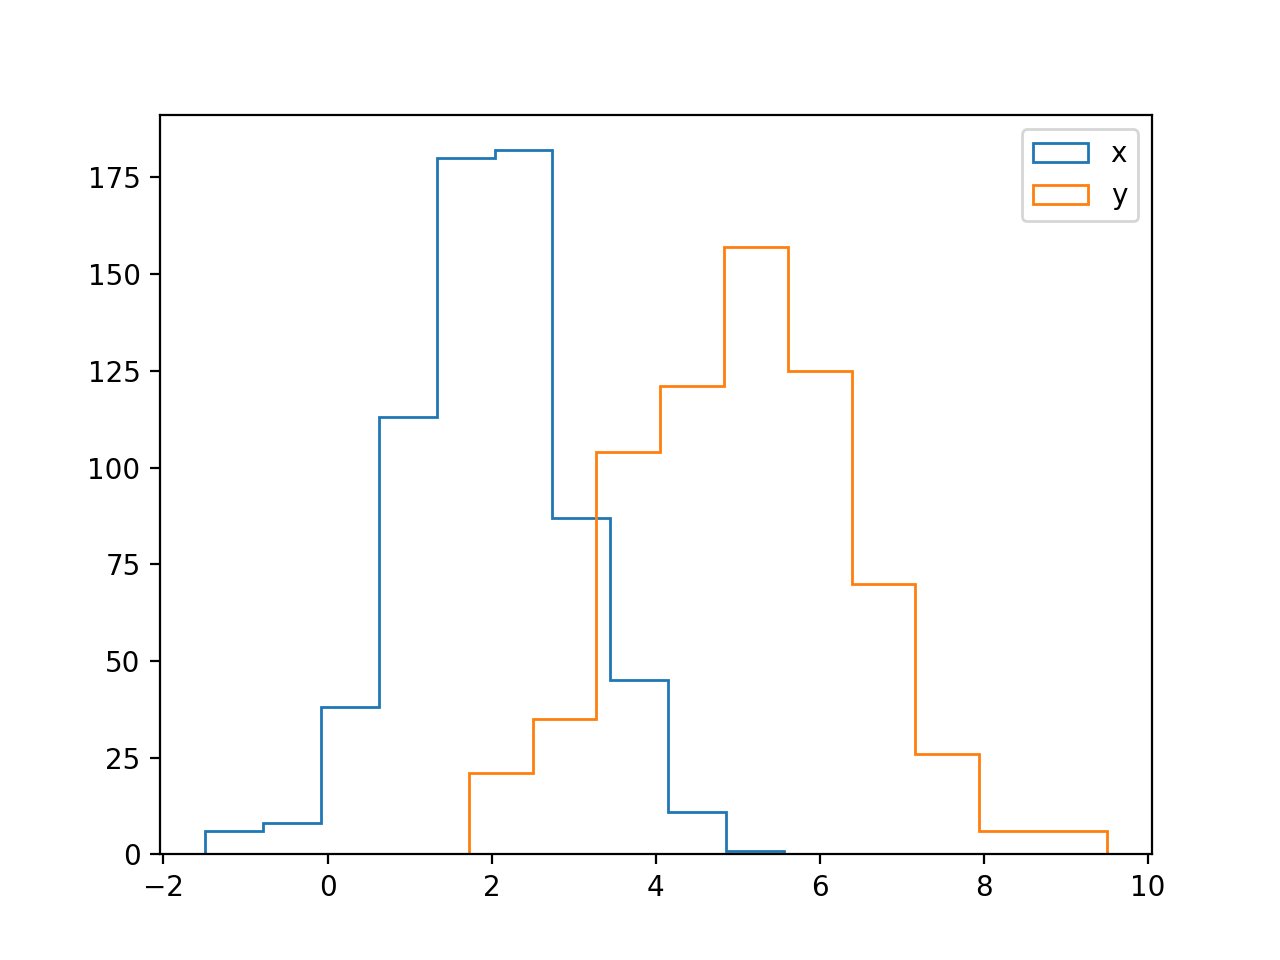

In [31]:
# histogram them
fig, ax = pyplot.subplots()
ax.hist(posterior['x'], bins=10, histtype='step', label='x')
ax.hist(posterior['y'], bins=10, histtype='step', label='y')
ax.legend()
fig.show()

Let's check the mean and variance of our estimated posterior. These should be $\bar{x} \approx 2, \sigma^2_{x} \approx 1$ and $\bar{y} \approx 5, \sigma^2_{y} \approx 2$:

In [32]:
for param in posterior:
    s = posterior[param]
    print(param, 'mean: {}'.format(s.mean()), 'var: {}'.format(s.var()))

x mean: 2.0015658834652976 var: 1.028395579566162
y mean: 5.080614600474179 var: 1.7903709480846135
